In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from video_prediction import datasets

## Example: bair

In [ ]:
dataset = 'bair'
input_dir = '/data/vision/phillipi/gen-models/video_prediction/data/bair'
dataset_hparams = 'use_state=True'
batch_size = 16

In [ ]:
VideoDataset = datasets.get_dataset_class(dataset)
train_dataset = VideoDataset(
    input_dir,
    mode='train',
    hparams=dataset_hparams)
train_tf_dataset = train_dataset.make_dataset(batch_size)
train_iterator = train_tf_dataset.make_one_shot_iterator()
train_handle = train_iterator.string_handle()
iterator = tf.data.Iterator.from_string_handle(
    train_handle, train_tf_dataset.output_types, train_tf_dataset.output_shapes)
inputs = iterator.get_next()

In [ ]:
print(inputs.keys())
sess = tf.Session()
x = sess.run(inputs)
print(x['images'].shape, x['states'].shape, x['actions'].shape)

---

## Helper function for read/write tfrecord

In [2]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _bytes_list_feature(values):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=values))


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _floats_list_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def save_tf_record(output_fname, sequences):
    print('saving sequences to %s' % output_fname)
    with tf.python_io.TFRecordWriter(output_fname) as writer:
        for (images, metadata, push_name, shape_ids) in sequences:
            assert len(images) == len(metadata)
            num_frames = len(images)
            encoded_images = [image.tostring() for image in images]
            states = np.concatenate((metadata[:, :2], np.zeros((num_frames, 1))), axis=1).reshape(-1)
            actions = np.repeat(metadata[:-1, 2], 4)
            shape_ids = np.array(shape_ids)
            features = tf.train.Features(feature={
                'images/encoded': _bytes_list_feature(encoded_images),
                'actions': _floats_list_feature(actions),
                'states': _floats_list_feature(states),
                'sequence_length': _int64_feature(num_frames),
                'push_name': _bytes_feature(push_name),
                'shape_ids': _floats_list_feature(shape_ids)
            })
            example = tf.train.Example(features=features)
            writer.write(example.SerializeToString())

## Example: omnipush_stitch

In [3]:
import glob
import os
import numpy as np
from skimage.io import imread
dataset = 'no_weight_processed_stitch'
dataset_dir = '/home/yenchenl/Workspace/data/omnipush/{}/'.format(dataset)
output_dir = '/home/yenchenl/Workspace/savp-omnipush/data/omnipush/{}/'.format(dataset)
splits = ['train', 'val']
for split in splits:
    split_path = os.path.join(output_dir, split)
    if not os.path.exists(split_path):
        os.makedirs(split_path)

## Write tfrecord

In [15]:
# Build class id mapping
shape_names = sorted(os.listdir(os.path.join(dataset_dir, 'train')))
mapping = {}
for class_id, shape_name in enumerate(shape_names):
    mapping[shape_name] = class_id

n_trajs = 0
splits = ['train', 'test']
for split in splits:
    shape_names = os.listdir(os.path.join(dataset_dir, '{}/'.format(split)))
    for shape_name in shape_names:
        sequences = []
        dnames = glob.glob(os.path.join(dataset_dir, '{}/{}/**/'.format(split, shape_name)))
        for dname in dnames:
            n_images = len(glob.glob(os.path.join(dname, '*.png')))
            images = []
            for i in range(n_images):
                fname = os.path.join(dname, '{}.png'.format(i))
                images.append(imread(fname))
            metadata = np.load(os.path.join(dname, 'actions.npy'))
            push_name = str.encode(dname.split('/')[-2])
            shape_ids = [mapping[shape_name]] * n_images
            sequences.append((images, metadata, push_name, shape_ids))
            n_trajs += 1
        output_split = 'val' if split == 'test' else 'train'
        save_tf_record('/home/yenchenl/Workspace/savp-omnipush/data/omnipush/{}/{}/{}.tfrecord'.format(dataset, output_split, shape_name), sequences)
        
print(n_trajs)

saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/train/2a2a2a2a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/train/2a3a4a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/train/2a3a4a3a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/train/1a2a3a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/train/2a4a3a3a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/train/1a3a3a2a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/train/3a4a3a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/train/2a3a2a4a.tfrecord
saving s

saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/train/2a2a4a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/train/1a2a3a2a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/train/1a1a3a3a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/val/2a2a2a2a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/val/2a3a4a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/val/2a3a4a3a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/val/1a2a3a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/val/2a4a3a3a.tfrecord
saving sequences t

saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/val/1a3a3a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/val/1a4a4a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/val/2a2a4a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/val/1a2a3a2a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch/val/1a1a3a3a.tfrecord
4708


## Load tfrecord

In [6]:
dataset = 'no_weight_processed_stitch'
dataset_class = 'omnipush'
input_dir = '/home/yenchenl/Workspace/savp-omnipush/data/omnipush/{}'.format(dataset)
print(input_dir)
dataset_hparams = 'use_state=True'
batch_size = 16

/home/yenchenl/Workspace/savp-omnipush/data/omnipush/no_weight_processed_stitch


In [7]:
VideoDataset = datasets.get_dataset_class(dataset_class)
train_dataset = VideoDataset(
    input_dir,
    mode='train',
    hparams=dataset_hparams)

train_tf_dataset = train_dataset.make_dataset(batch_size)
train_iterator = train_tf_dataset.make_one_shot_iterator()
train_handle = train_iterator.string_handle()
iterator = tf.data.Iterator.from_string_handle(
    train_handle, train_tf_dataset.output_types, train_tf_dataset.output_shapes)
inputs = iterator.get_next()

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.data.experimental.shuffle_and_repeat(...)`.
Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


In [8]:
print(inputs.keys())

sess = tf.Session()
x = sess.run(inputs)
print(x['images'].shape, x['states'].shape, x['actions'].shape, x['push_name'], x['shape_ids'])

odict_keys(['images', 'states', 'shape_ids', 'push_name', 'actions'])
(16, 12, 64, 64, 3) (16, 12, 3) (16, 11, 4) [[b'motion_surface=abs_shape=1a3a3a3a_v=50_rep=0043_push=0000_t=-3.110']
 [b'motion_surface=abs_shape=1a4a3a3a_v=50_rep=0034_push=0000_t=0.125']
 [b'motion_surface=abs_shape=1a2a4a3a_v=50_rep=0065_push=0000_t=0.580']
 [b'motion_surface=abs_shape=1a1a1a4a_v=50_rep=0028_push=0000_t=-1.580']
 [b'motion_surface=abs_shape=1a1a3a4a_v=50_rep=0001_push=0000_t=-0.411']
 [b'motion_surface=abs_shape=1a1a4a2a_v=50_rep=0061_push=0000_t=2.536']
 [b'motion_surface=abs_shape=1a1a4a2a_v=50_rep=0006_push=0000_t=2.242']
 [b'motion_surface=abs_shape=1a2a1a3a_v=50_rep=0028_push=0000_t=-1.653']
 [b'motion_surface=abs_shape=1a1a3a4a_v=50_rep=0030_push=0000_t=-2.056']
 [b'motion_surface=abs_shape=4a4a4a4a_v=50_rep=0033_push=0000_t=2.791']
 [b'motion_surface=abs_shape=1a2a1a4a_v=50_rep=0037_push=0000_t=-1.186']
 [b'motion_surface=abs_shape=1a2a3a2a_v=50_rep=0029_push=0000_t=-0.927']
 [b'motion_surf

## Visualize data from tfrecord

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

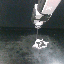

[54.257145 54.257145 54.257145 54.257145 54.257145 54.257145 54.257145
 54.257145 54.257145 54.257145 54.257145]


In [11]:
import imageio
from IPython.display import Image
from IPython.display import display
from IPython.display import clear_output
def inspect_seq(seq):
    clear_output(wait=True)
    if os.path.exists('./tmp.gif'):
        os.remove('./tmp.gif')
    imageio.mimsave('./tmp.gif', seq)
    with open('./tmp.gif','rb') as f:
        display(Image(data=f.read(), format='gif', width=200, height=200))

idx = 10
inspect_seq(x['images'][idx])
print(x['actions'][idx, :, 0] / np.pi * 180)

## Optional: Write tfrecord with different actions to test generalizatoin of action-conditional video prediction

In this example, we modify all the actions to 0.5 pi

In [14]:
modify_action = True
n_trajs = 0
splits = ['test']
for split in splits:
    shape_names = os.listdir(os.path.join(dataset_dir, '{}/'.format(split)))
    for shape_name in shape_names:
        sequences = []
        dnames = glob.glob(os.path.join(dataset_dir, '{}/{}/**/'.format(split, shape_name)))
        for dname in dnames:
            n_images = len(glob.glob(os.path.join(dname, '*.png')))
            images = []
            for i in range(n_images):
                fname = os.path.join(dname, '{}.png'.format(i))
                images.append(imread(fname))
            metadata = np.load(os.path.join(dname, 'actions.npy'))
            # Modify the action here
            if modify_action:
                # Note: change all metadata to 0.5 pi!
                metadata = np.ones(metadata.shape) * np.pi / 2
            push_name = str.encode(dname.split('/')[-2])
            shape_ids = [mapping[shape_name]] * n_images
            sequences.append((images, metadata, push_name, shape_ids))
            n_trajs += 1
        output_split = 'val_actions=0.5pi' if split == 'test' else 'train'
        path = '/home/yenchenl/Workspace/savp-omnipush/data/{}/{}'.format(dataset, output_split)
        if not os.path.exists(path):
            os.makedirs(path)
        save_tf_record('/home/yenchenl/Workspace/savp-omnipush/data/{}/{}/{}.tfrecord'.format(dataset, output_split, shape_name), sequences)
        
print(n_trajs)

saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/no_weight_processed_stitch/val_actions=0.5pi/2a2a2a2a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/no_weight_processed_stitch/val_actions=0.5pi/2a3a4a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/no_weight_processed_stitch/val_actions=0.5pi/2a3a4a3a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/no_weight_processed_stitch/val_actions=0.5pi/1a2a3a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/no_weight_processed_stitch/val_actions=0.5pi/2a4a3a3a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/no_weight_processed_stitch/val_actions=0.5pi/1a3a3a2a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/no_weight_processed_stitch/val_actions=0.5pi/3a4a3a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/no_weight_processed_stitch/val_actions=0.5pi/2a

saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/no_weight_processed_stitch/val_actions=0.5pi/1a4a4a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/no_weight_processed_stitch/val_actions=0.5pi/2a2a4a4a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/no_weight_processed_stitch/val_actions=0.5pi/1a2a3a2a.tfrecord
saving sequences to /home/yenchenl/Workspace/savp-omnipush/data/no_weight_processed_stitch/val_actions=0.5pi/1a1a3a3a.tfrecord
700
